In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import emcee 
import pyimfit 
from astropy.io import fits
import corner
from IPython.display import Latex
import sys
import warnings

from photutils.detection import find_peaks
from photutils.aperture import CircularAperture
from astropy.visualization import simple_norm
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
from photutils.psf import extract_stars
from photutils.psf import EPSFBuilder


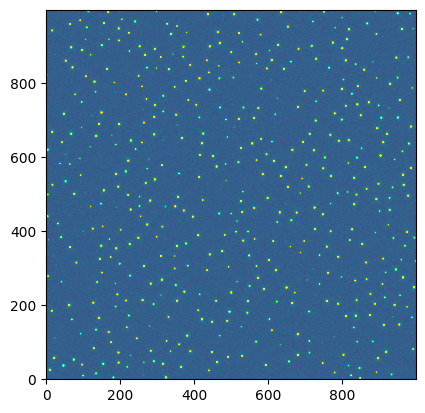

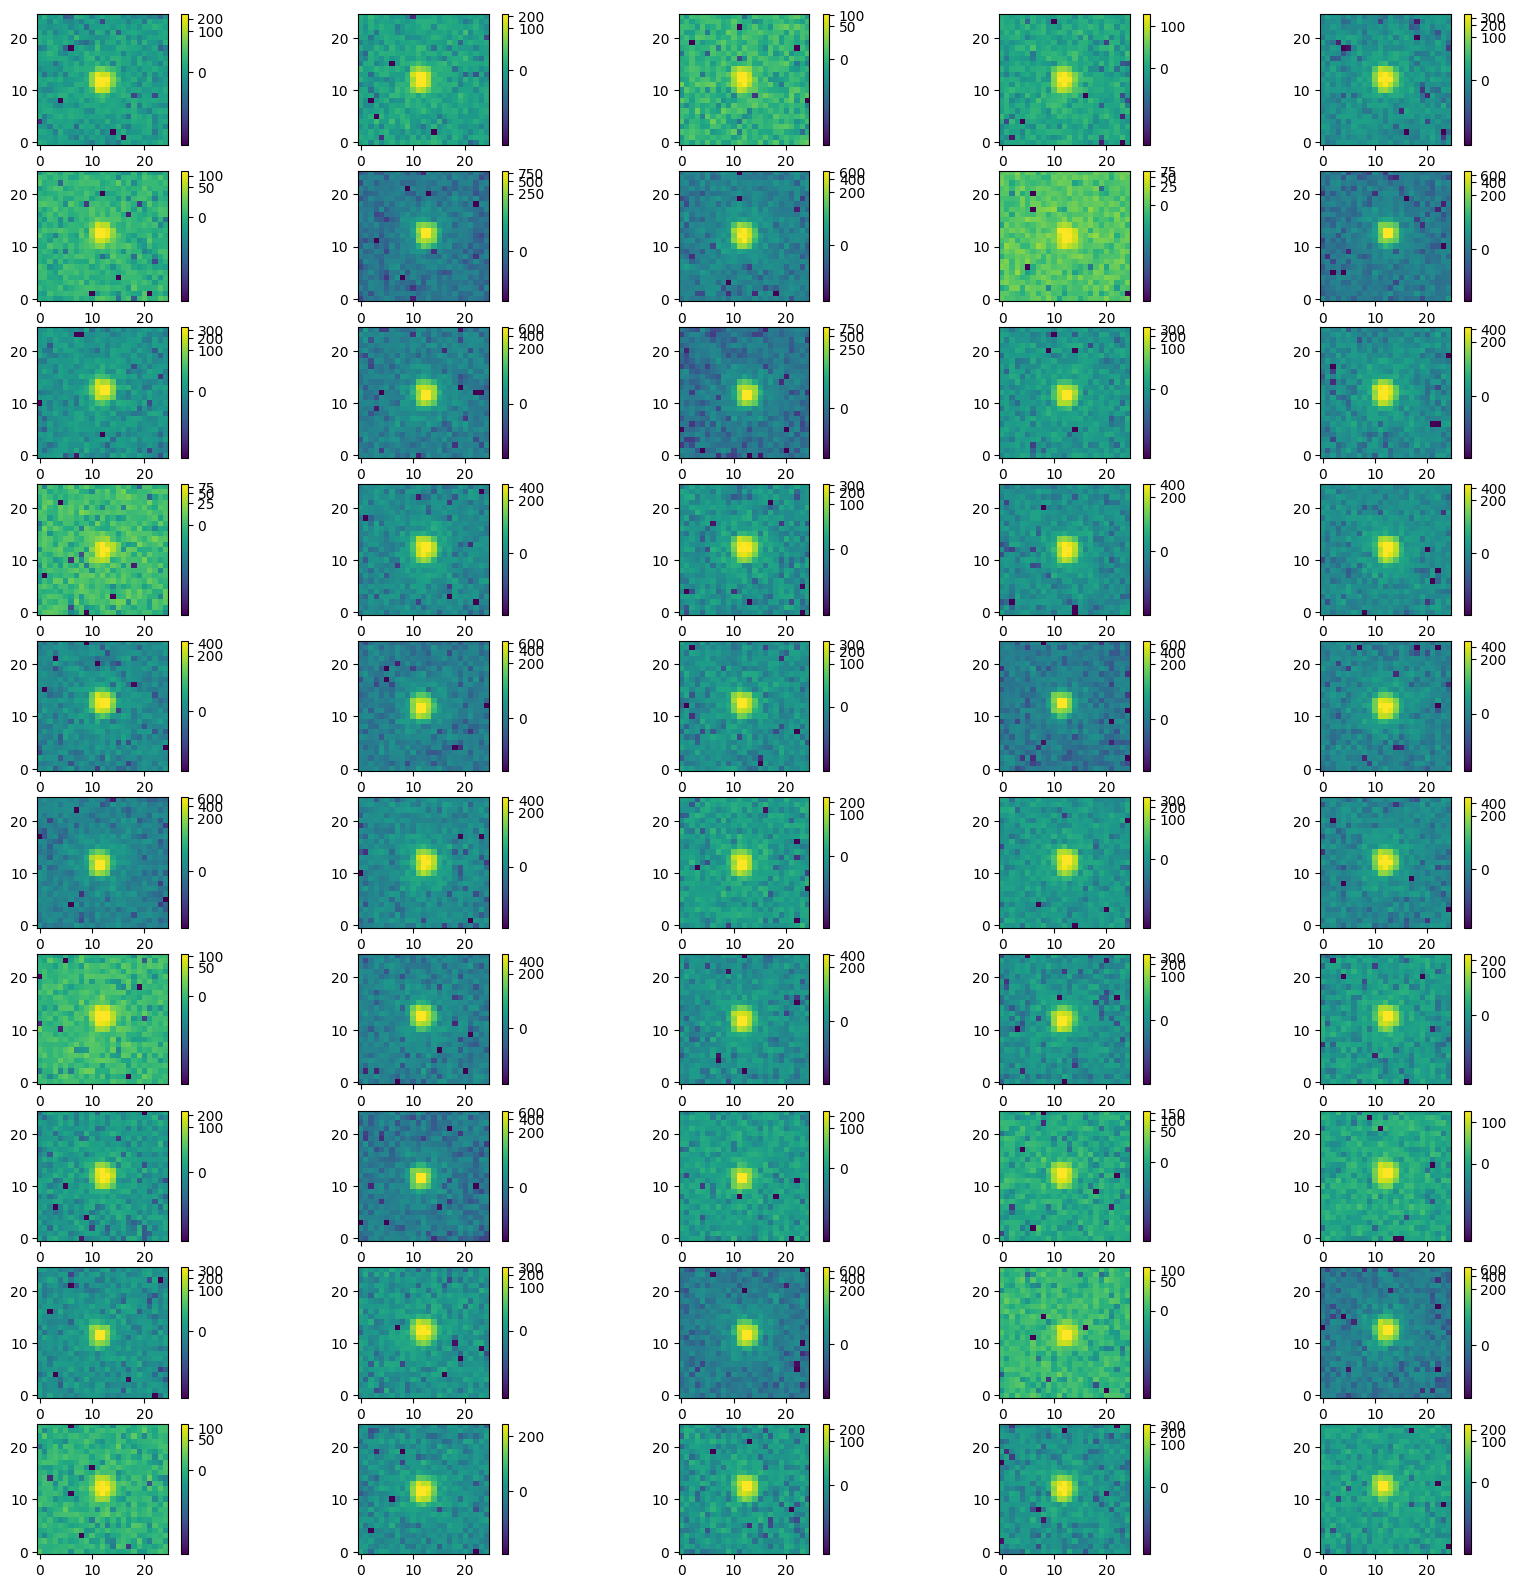

In [2]:
from photutils.datasets import load_simulated_hst_star_image
from photutils.datasets import make_noise_image
from astropy.table import Table
hdu = load_simulated_hst_star_image()  
data = hdu.data  
data += make_noise_image(data.shape, distribution='gaussian',
                         mean=10.0, stddev=5.0, seed=123)  

hdu = load_simulated_hst_star_image()
data = hdu.data
data += make_noise_image(data.shape, distribution='gaussian', mean=10.0,
                         stddev=5.0, seed=123)
norm = simple_norm(data, 'sqrt', percent=99.0)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
peaks_tbl = find_peaks(data, threshold=500.0) 
size = 25
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))  
stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask] 
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.0)  
data -= median_val  
nddata = NDData(data=data)  
stars = extract_stars(nddata, stars_tbl, size=25)  
nrows = 10
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.0)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax[i])

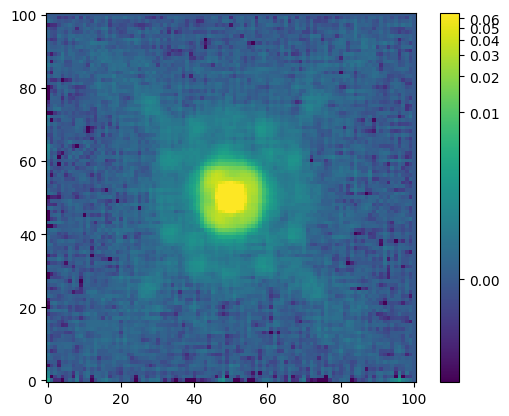

In [3]:
epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars)  
norm = simple_norm(epsf.data, 'log', percent=99.0)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

Text(0.5, 0.98, 'PSF residual')

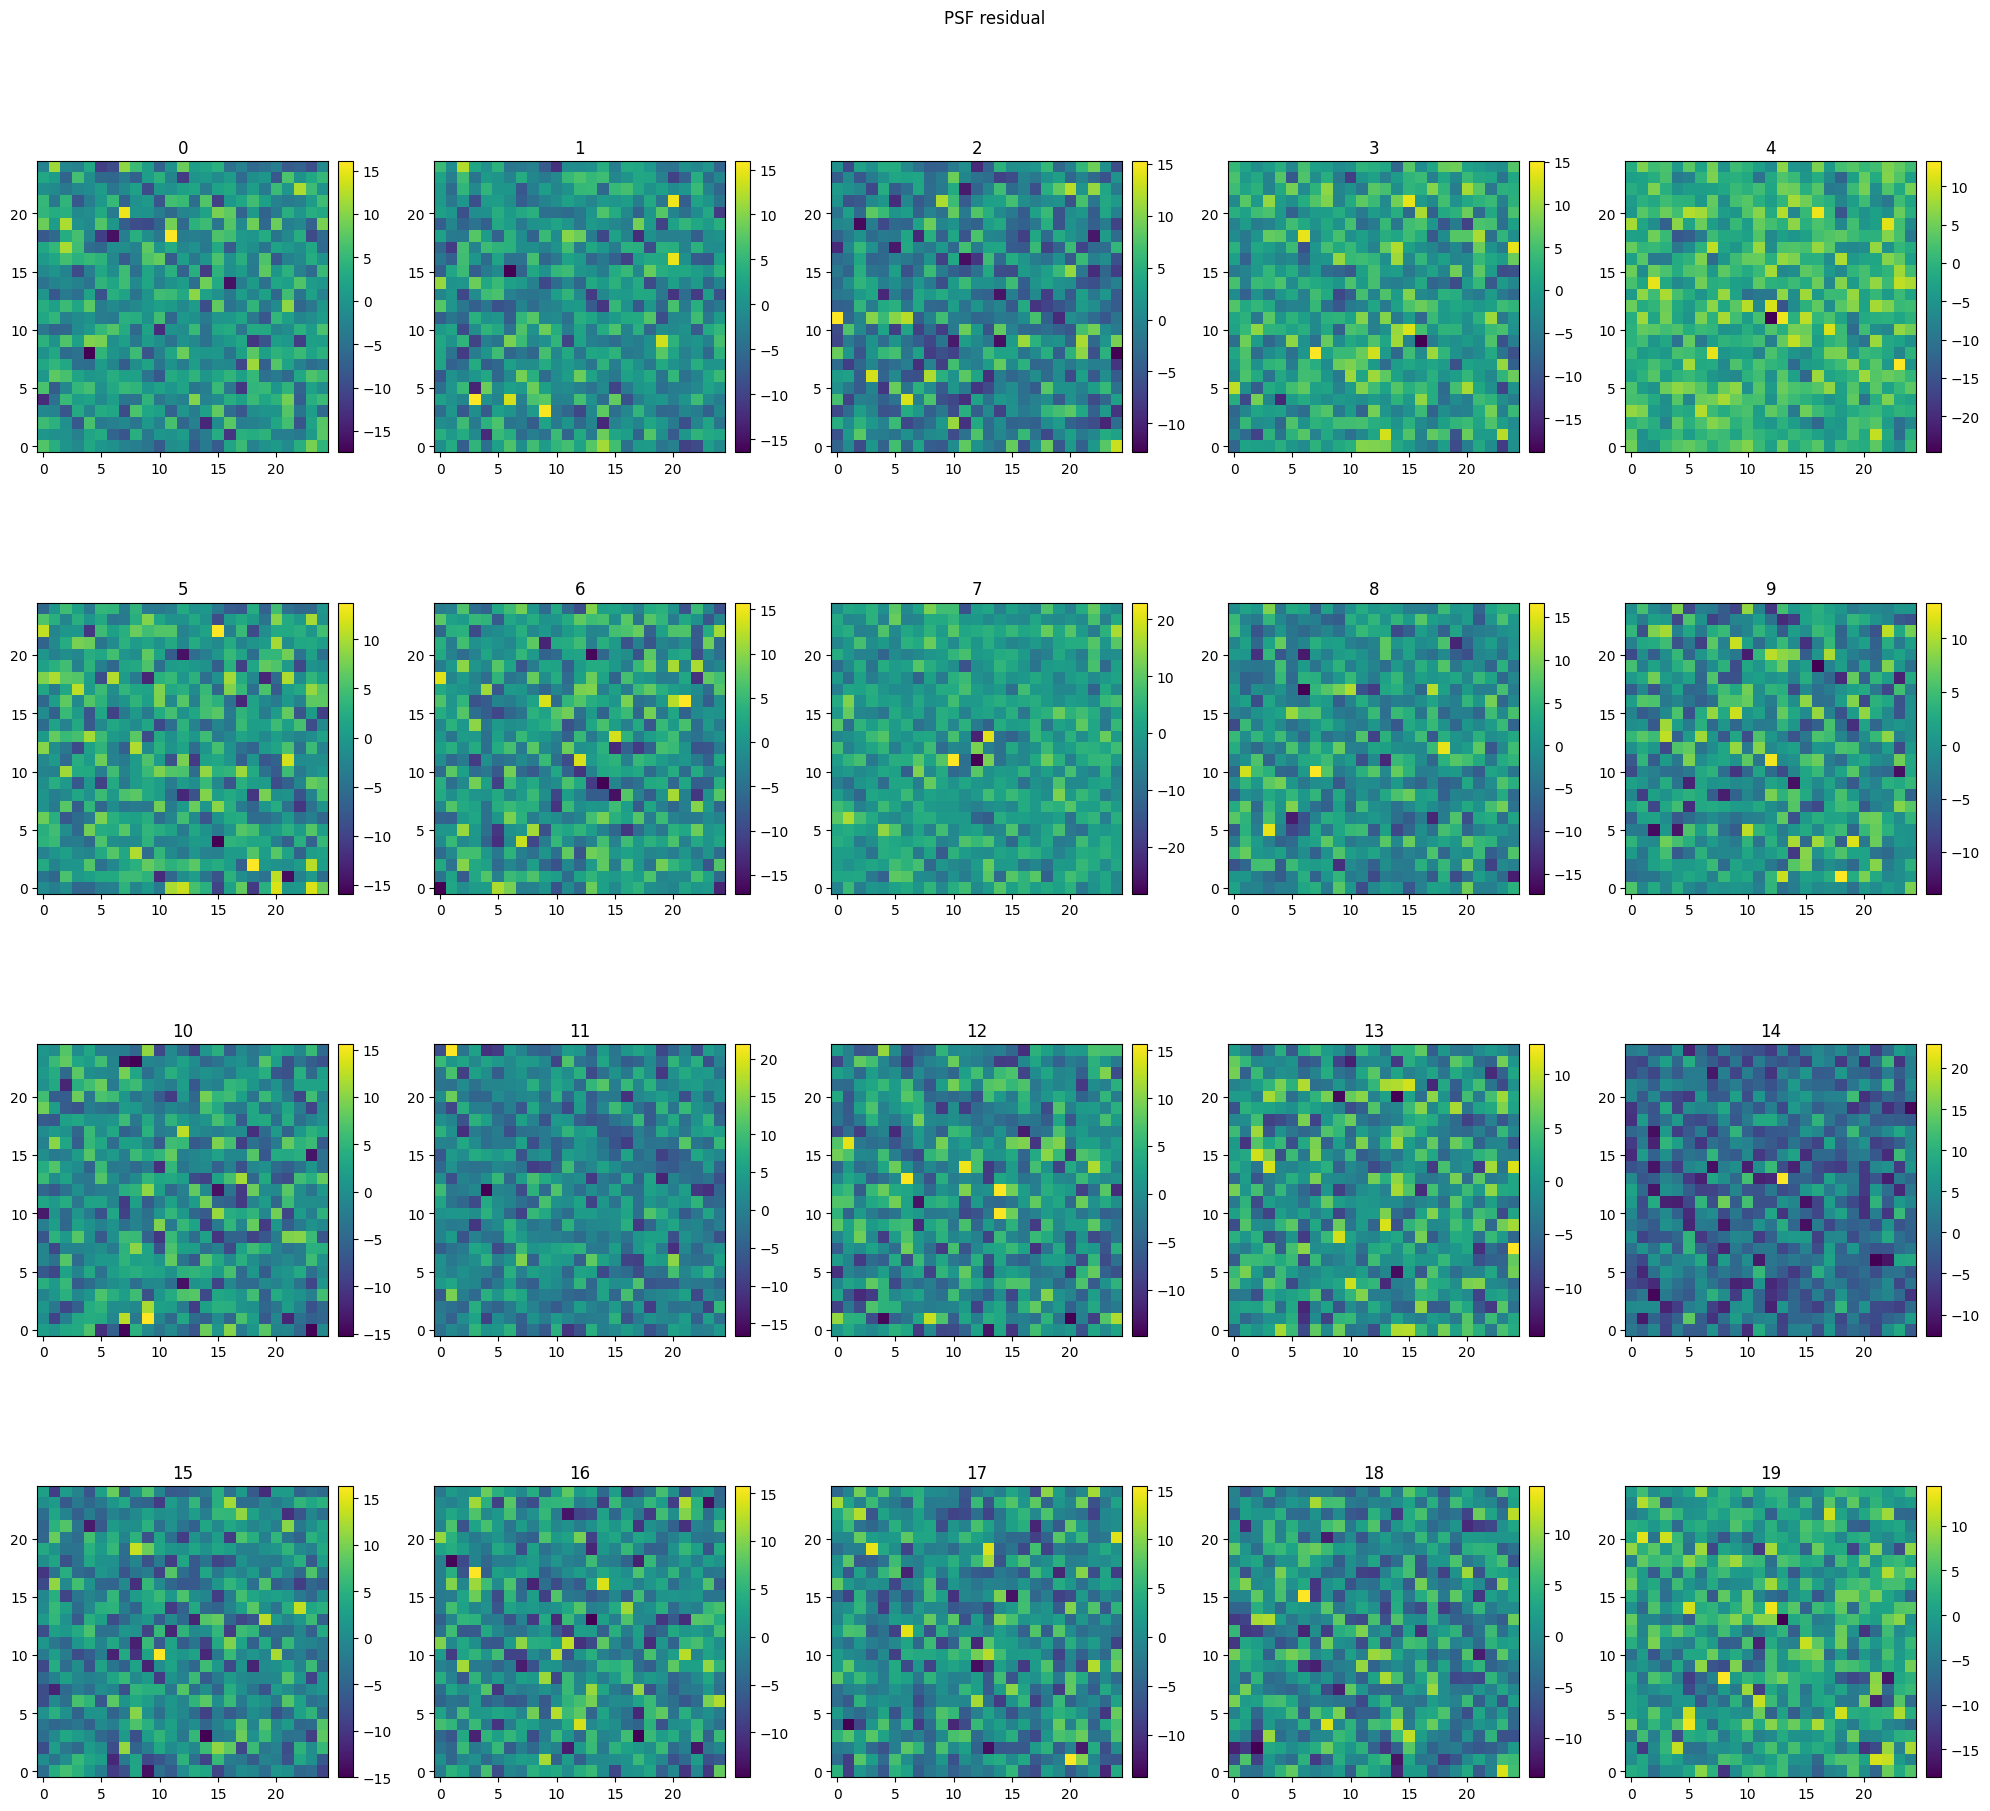

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
nrows = 4
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    im = ax[i].imshow(fitted_stars[i].compute_residual_image(epsf), origin='lower', cmap='viridis')
    ax[i].set_title(i)
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbr = plt.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout()

fig.suptitle("PSF residual")

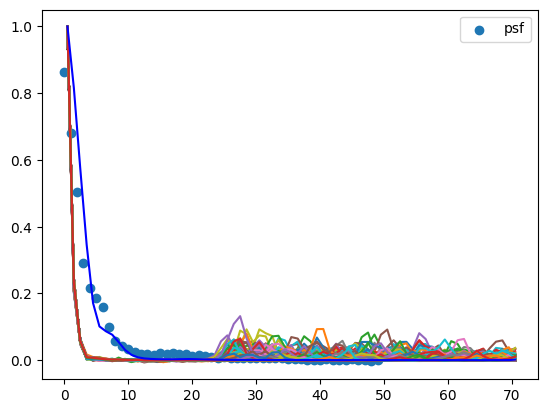

In [7]:
from photutils import profiles
for i in range(len(stars)):
    rp_star = profiles.RadialProfile(data,xycen=fitted_stars[i].center_flat[0],radii=np.arange(72))
    plt.plot(rp_star.radius,rp_star.profile/np.max(rp_star.profile))
rf_psf = np.sum(epsf.data, axis=0)/np.sum(epsf.data, axis=0).max()
plt.scatter(np.arange(rf_psf.shape[0]//2),rf_psf[rf_psf.shape[0]//2+1:],label="psf")

rp_psf = profiles.RadialProfile(epsf.data,xycen=(50,50),radii = np.arange(72))
plt.plot(rp_psf.radius, rp_psf.profile/np.max(rp_psf.profile),"b")
plt.legend();